In [30]:
from dataloader import load_parquet
#THIS_PATH = os.path.dirname(os.path.realpath(__file__))
MY_FILE = "aisdk-2025-02-27"
df = load_parquet(MY_FILE)
print(df.head())

             MMSI           Timestamp   Latitude  Longitude       SOG  \
0  MMSI=211190000 2025-02-27 00:00:00  54.576005  11.285075  6.866474   
1  MMSI=211190000 2025-02-27 00:06:00  54.596526  11.299219  6.894940   
2  MMSI=211190000 2025-02-27 00:12:00  54.617363  11.312855  6.882426   
3  MMSI=211190000 2025-02-27 00:18:00  54.638601  11.329810  6.293365   
4  MMSI=211190000 2025-02-27 00:24:00  54.650462  11.345175  3.580530   

         COG  Segment             x             y  
0  22.821053      0.0  1.256249e+06  7.280008e+06  
1  20.854054      0.0  1.257823e+06  7.283951e+06  
2  20.786486      0.0  1.259341e+06  7.287955e+06  
3  31.408889      0.0  1.261229e+06  7.292040e+06  
4  41.867500      0.0  1.262939e+06  7.294321e+06  


/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")


http://aisdata.ais.dk/!_README_information_CSV_files.txt

SOG =  Speed over ground from AIS message if available

COG = Course over ground from AIS message if available

Segment = Divide track into segments based on timegap (he created this in a script)
"Copilot explanation: " Segment splits a vessel's time-ordered AIS track into contiguous sub-tracks whenever there's a large time gap between consecutive messages. This prevents treating long gaps (e.g., device off, no reception) as part of the same continuous trajector""

MMSI = Marinetime Mobile Service Identity (unique 9 digit identifier)

In [31]:
# Exploration imports and load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_parquet
from dataloader import preprocess_data
from dataloader import plot_paths_on_map
from dataloader import get_ID_by_coords
from dataloader import SlidingWindowDataset
from dataloader import plot_paths_on_map

plt.rcParams['figure.figsize'] = (10, 5)

MY_FILE = "aisdk-2025-02-27"

df = load_parquet(MY_FILE, k=100)
df = preprocess_data(df)
dataset = SlidingWindowDataset(
        df,
        max_diff_per_sequence_minutes=30,
        window_size_minutes=60,
        pred_size_minutes=30,
        stride=12,
    )
x, y = dataset[0]

/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")
/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_in

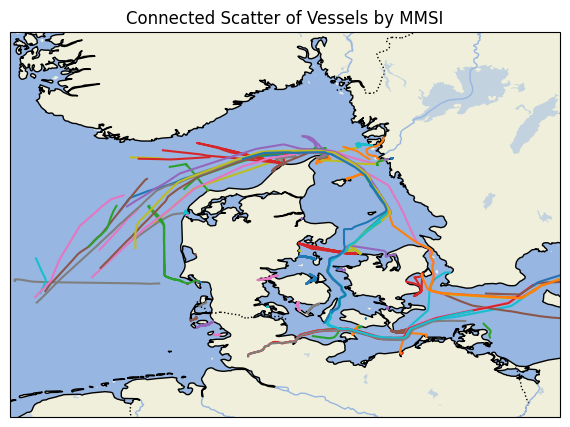

In [32]:
plot_paths_on_map(df)

## Temporal Analysis

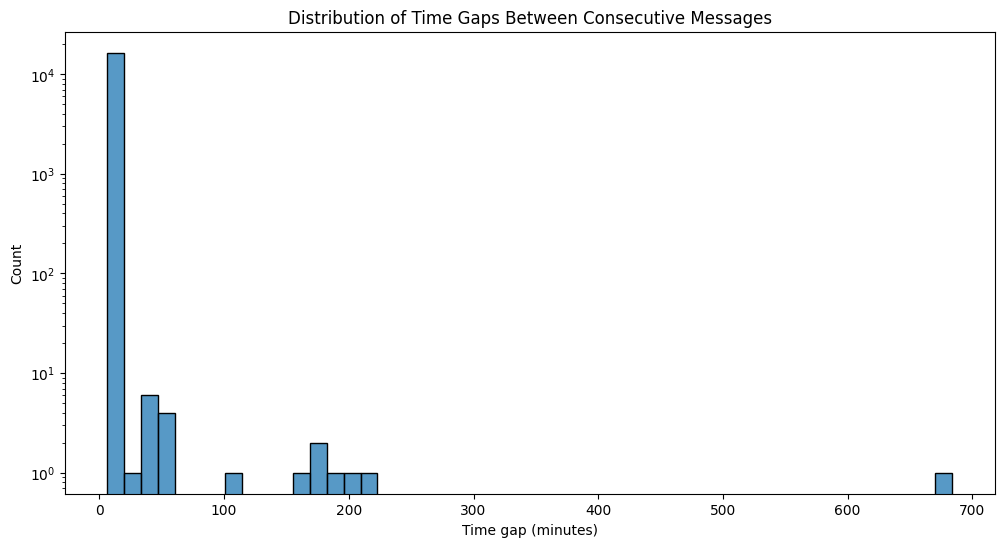


Time gap statistics (minutes):
count    16429.000000
mean         6.159961
std          6.463527
min          6.000000
25%          6.000000
50%          6.000000
75%          6.000000
max        684.000000
Name: time_diff_minutes, dtype: float64


In [33]:
# Analyze message frequency and time gaps
# Sort data by MMSI and timestamp
df_sorted = df.sort_values(['MMSI', 'Timestamp'])

# Calculate time differences between consecutive messages for each vessel
df_sorted['time_diff'] = df_sorted.groupby('MMSI')['Timestamp'].diff()
df_sorted['time_diff_minutes'] = df_sorted['time_diff'].dt.total_seconds() / 60

# Plot distribution of time gaps
plt.figure(figsize=(12, 6))
sns.histplot(df_sorted['time_diff_minutes'].dropna(), bins=50)
plt.title('Distribution of Time Gaps Between Consecutive Messages')
plt.xlabel('Time gap (minutes)')
plt.ylabel('Count')
plt.yscale('log')  # Log scale for better visualization
plt.show()

# Calculate and show statistics
print("\nTime gap statistics (minutes):")
print(df_sorted['time_diff_minutes'].describe())

## Average Messages For Hour

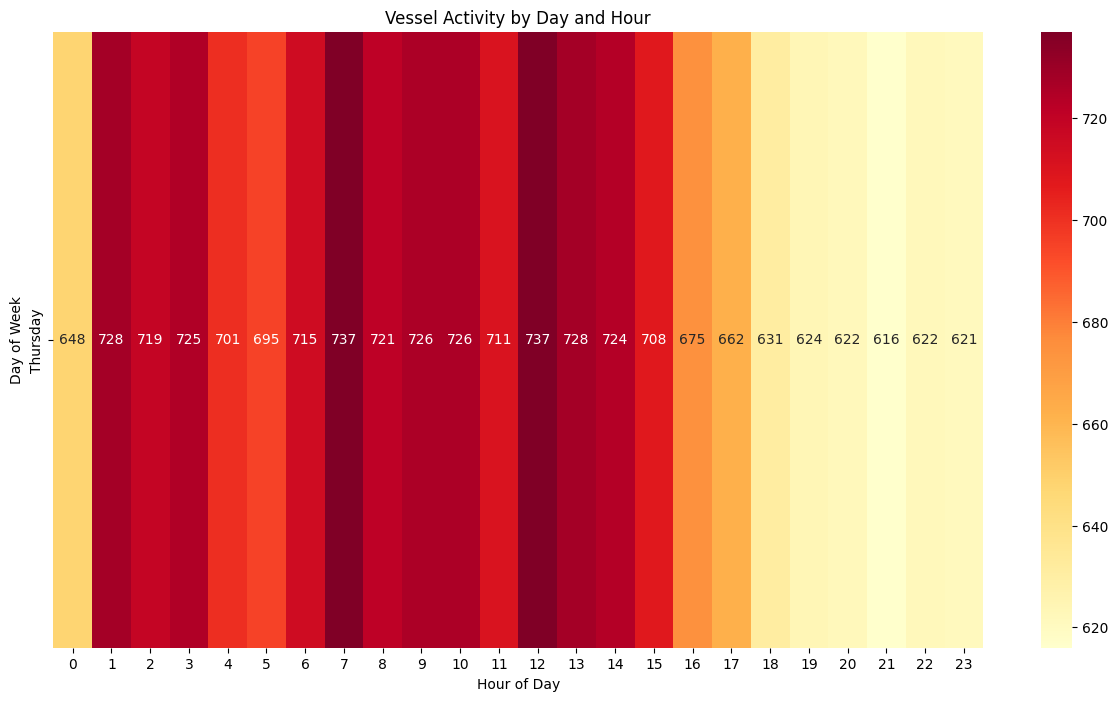


Average messages per hour:
count     24.000000
mean     688.416667
std       44.551794
min      616.000000
25%      643.750000
50%      709.500000
75%      725.250000
max      737.000000
dtype: float64


In [34]:
# Analyze daily and hourly patterns
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.day_name()

# Create pivot table for heatmap
activity_matrix = pd.crosstab(df['day_of_week'], df['hour'])

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(activity_matrix, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Vessel Activity by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Show hourly statistics
print("\nAverage messages per hour:")
print(df.groupby('hour').size().describe())

## Distance and Speed Distribution

/tmp/ipykernel_3794383/4176309117.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorted['distance_km'] = df_sorted.groupby('MMSI').apply(


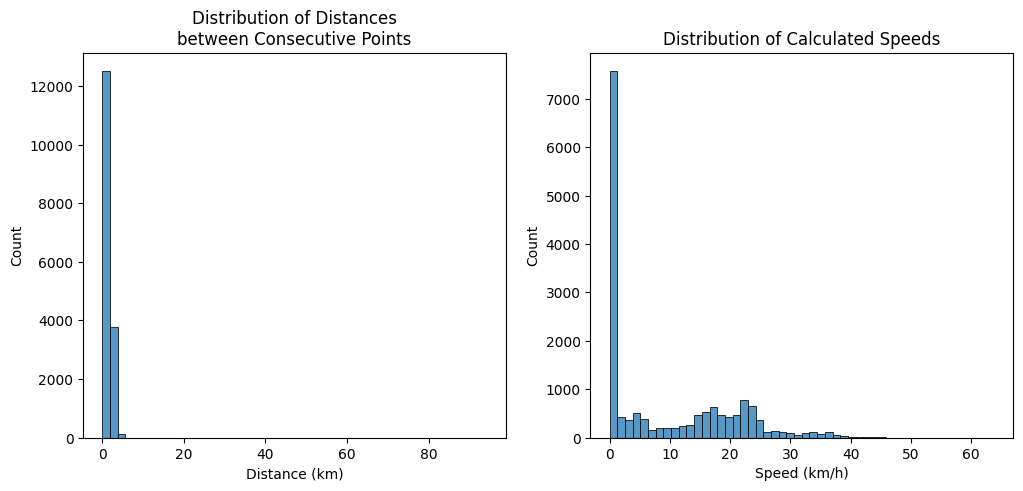


Distance statistics (km):
count    16429.000000
mean         0.967645
std          1.853986
min          0.000000
25%          0.001813
50%          0.344631
75%          1.833691
max         94.243736
Name: distance_km, dtype: float64

Calculated speed statistics (km/h):
count    16429.000000
mean         9.244262
std         10.779763
min          0.000000
25%          0.018090
50%          3.441751
75%         18.303545
max         63.778347
Name: calculated_speed, dtype: float64


In [35]:
# Calculate distances and analyze movement patterns
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

# Calculate distances between consecutive points for each vessel
df_sorted['distance_km'] = df_sorted.groupby('MMSI').apply(
    lambda x: pd.Series(
        [haversine_distance(lat1, lon1, lat2, lon2) 
         for lat1, lon1, lat2, lon2 
         in zip(x['Latitude'].iloc[:-1], x['Longitude'].iloc[:-1],
               x['Latitude'].iloc[1:], x['Longitude'].iloc[1:])],
        index=x.index[1:]
    )
).reset_index(level=0, drop=True)

# Calculate speed between points (km/h)
df_sorted['calculated_speed'] = df_sorted['distance_km'] / (df_sorted['time_diff'].dt.total_seconds() / 3600)

# Analyze and plot distance distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_sorted['distance_km'].dropna(), bins=50)
plt.title('Distribution of Distances\nbetween Consecutive Points')
plt.xlabel('Distance (km)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df_sorted['calculated_speed'].dropna(), bins=50)
plt.title('Distribution of Calculated Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Count')
plt.show()

# Print statistics
print("\nDistance statistics (km):")
print(df_sorted['distance_km'].describe())
print("\nCalculated speed statistics (km/h):")
print(df_sorted['calculated_speed'].describe())

## Distribution of Movement States

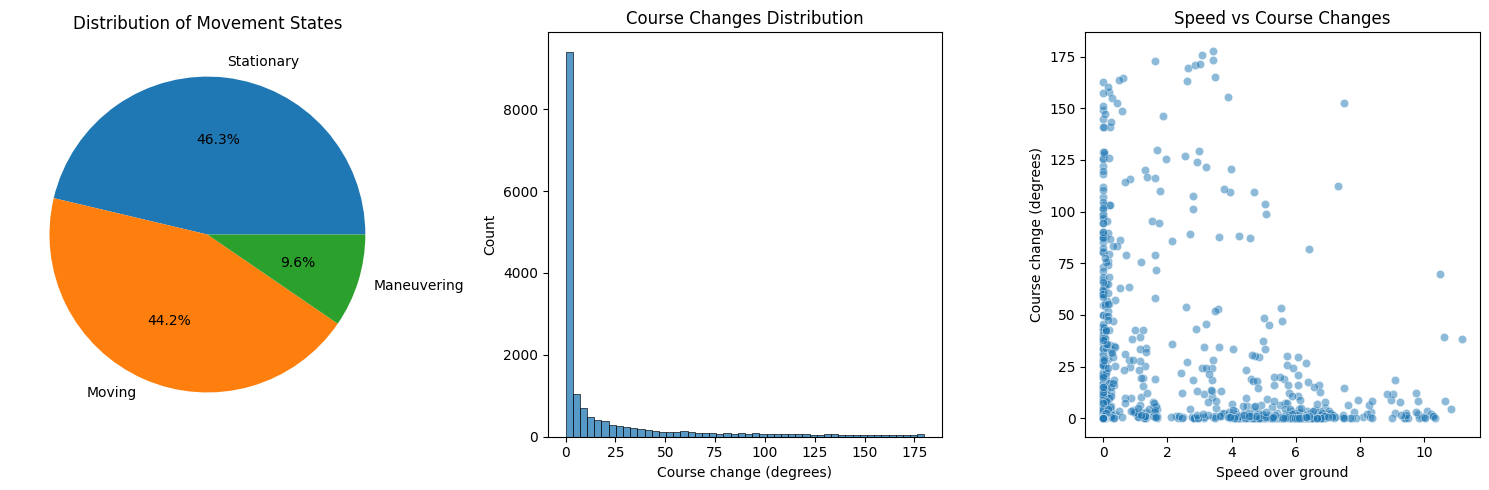


Movement state statistics:
movement_state
Stationary      46.3%
Moving         44.15%
Maneuvering     9.55%
Name: proportion, dtype: object

Course change statistics (degrees):
count    16429.000000
mean        20.803780
std         38.766430
min          0.000000
25%          0.079603
50%          1.564449
75%         20.679354
max        180.000000
Name: cog_change, dtype: float64


In [36]:
# Analyze movement states and behavior
def classify_movement_state(speed, course_change=None):
    if speed < 0.5:  # Very slow speed
        return 'Stationary'
    elif speed < 2:  # Slow speed
        return 'Maneuvering'
    else:
        return 'Moving'

# Calculate course changes
df_sorted['cog_change'] = df_sorted.groupby('MMSI')['COG'].diff().abs()
# Wrap around 360 degrees
df_sorted['cog_change'] = df_sorted['cog_change'].apply(lambda x: min(x, 360-x) if pd.notnull(x) else x)

# Classify movement states
df_sorted['movement_state'] = df_sorted['SOG'].apply(classify_movement_state)

# Plot movement states distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
movement_counts = df_sorted['movement_state'].value_counts()
plt.pie(movement_counts, labels=movement_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Movement States')

plt.subplot(1, 3, 2)
sns.histplot(df_sorted['cog_change'].dropna(), bins=50)
plt.title('Course Changes Distribution')
plt.xlabel('Course change (degrees)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_sorted.sample(1000), x='SOG', y='cog_change', alpha=0.5)
plt.title('Speed vs Course Changes')
plt.xlabel('Speed over ground')
plt.ylabel('Course change (degrees)')

plt.tight_layout()
plt.show()

# Print movement state statistics
print("\nMovement state statistics:")
print(df_sorted['movement_state'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nCourse change statistics (degrees):")
print(df_sorted['cog_change'].describe())

## Data Quality

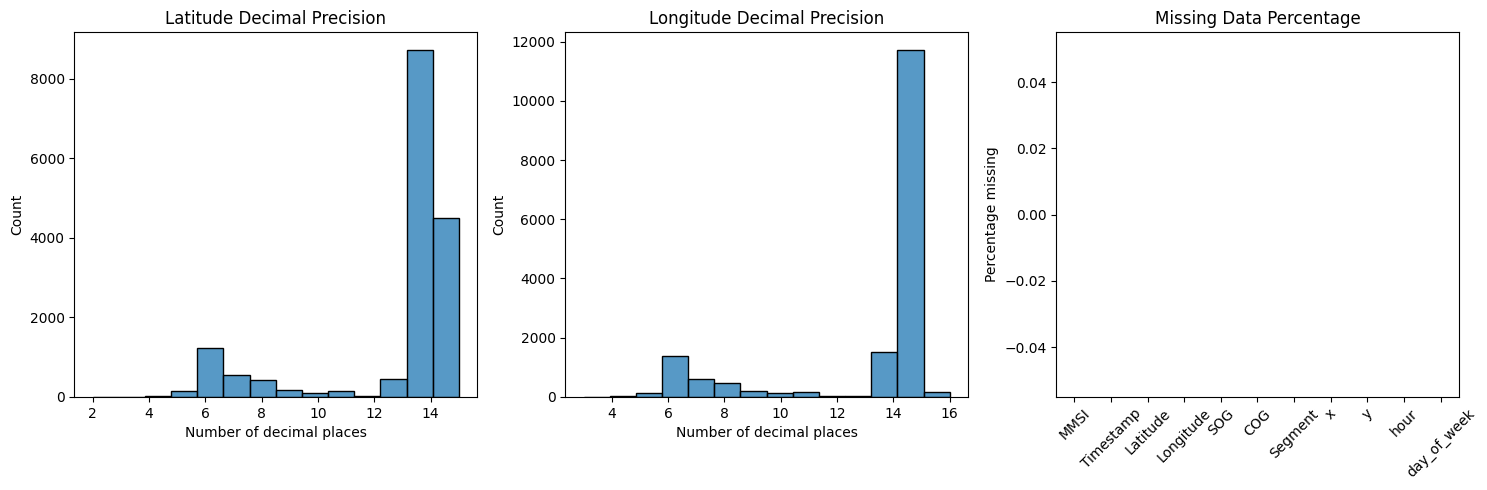


Speed outlier analysis:
Number of speed outliers: 9 (0.05%)

Data quality summary:
Average position precision: 13.1 decimal places (lat), 13.4 decimal places (lon)

Missing data percentages:
MMSI           0.0%
Timestamp      0.0%
Latitude       0.0%
Longitude      0.0%
SOG            0.0%
COG            0.0%
Segment        0.0%
x              0.0%
y              0.0%
hour           0.0%
day_of_week    0.0%
dtype: object


In [37]:
# Data quality analysis
# Calculate basic statistics for position precision
lat_decimals = df['Latitude'].astype(str).str.split('.').str[1].str.len()
lon_decimals = df['Longitude'].astype(str).str.split('.').str[1].str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(lat_decimals, bins=lat_decimals.nunique())
plt.title('Latitude Decimal Precision')
plt.xlabel('Number of decimal places')

plt.subplot(1, 3, 2)
sns.histplot(lon_decimals, bins=lon_decimals.nunique())
plt.title('Longitude Decimal Precision')
plt.xlabel('Number of decimal places')

plt.subplot(1, 3, 3)
missing_data = df.isna().sum() / len(df) * 100
missing_data.plot(kind='bar')
plt.title('Missing Data Percentage')
plt.ylabel('Percentage missing')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analyze potential outliers in speed and position
print("\nSpeed outlier analysis:")
speed_quantiles = df['SOG'].quantile([0.25, 0.75])
speed_iqr = speed_quantiles[0.75] - speed_quantiles[0.25]
speed_outliers = df[(df['SOG'] < speed_quantiles[0.25] - 1.5 * speed_iqr) | 
                    (df['SOG'] > speed_quantiles[0.75] + 1.5 * speed_iqr)]
print(f"Number of speed outliers: {len(speed_outliers)} ({len(speed_outliers)/len(df)*100:.2f}%)")

# Print data quality summary
print("\nData quality summary:")
print(f"Average position precision: {lat_decimals.mean():.1f} decimal places (lat), {lon_decimals.mean():.1f} decimal places (lon)")
print("\nMissing data percentages:")
print(missing_data.round(2).astype(str) + '%')

## I was trying to show the sliding windoe, but it seems weird to me

Input window shape: torch.Size([5, 4])
Prediction window shape: torch.Size([5, 2])

Input window features: [Latitude, Longitude, SOG, COG]
Prediction window features: [Latitude, Longitude]


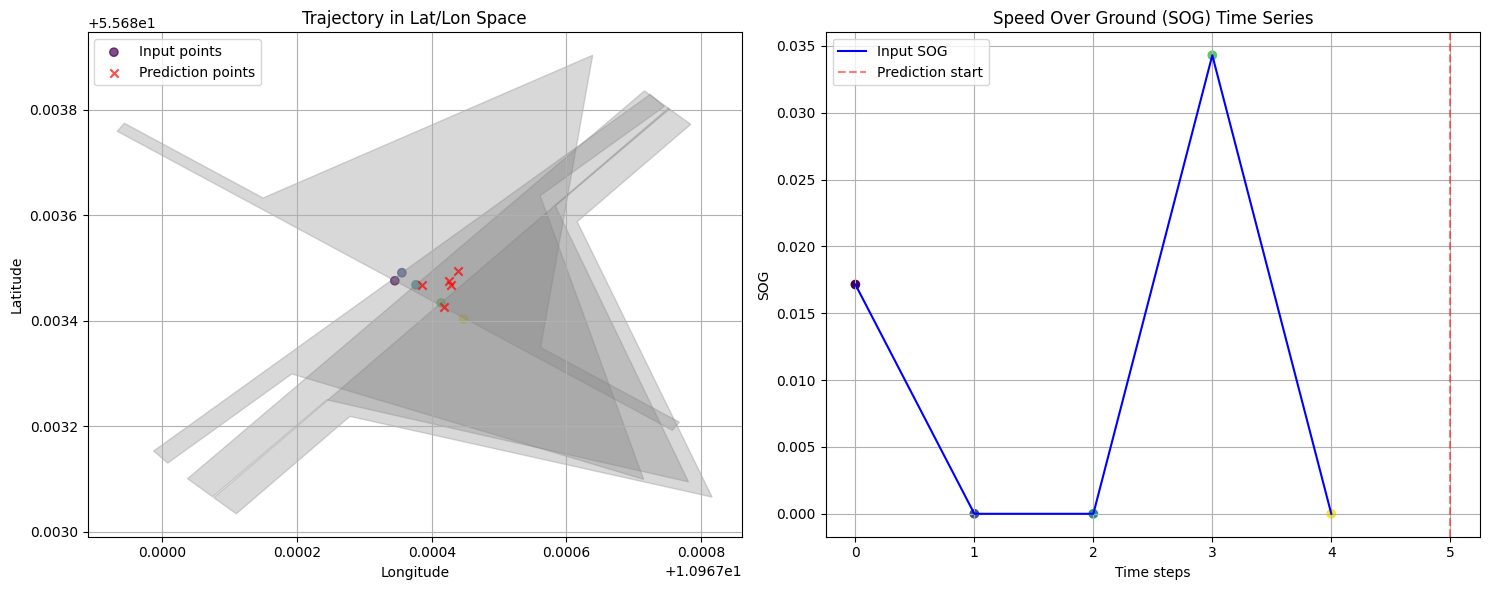

In [ ]:
import numpy as np
# Visualize sliding window example
def plot_sliding_window(x, y):
    plt.figure(figsize=(15, 6))
    
    # Plot input window points
    plt.subplot(1, 2, 1)
    plt.scatter(x[:, 1], x[:, 0], c=range(len(x)), cmap='viridis', 
                label='Input points', alpha=0.7)
    
    # Add arrows to show direction
    for i in range(len(x)-1):
        plt.arrow(x[i, 1], x[i, 0], 
                 x[i+1, 1] - x[i, 1], x[i+1, 0] - x[i, 0],
                 head_width=0.0005, head_length=0.0005, fc='gray', ec='gray', alpha=0.3)
    
    # Plot prediction window points
    plt.scatter(y[:, 1], y[:, 0], c='red', marker='x', 
                label='Prediction points', alpha=0.7)
    
    plt.title('Trajectory in Lat/Lon Space')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    
    # Plot the same data but showing temporal progression
    plt.subplot(1, 2, 2)
    time_input = np.arange(len(x))
    time_pred = np.arange(len(x), len(x) + len(y))
    
    plt.plot(time_input, x[:, 2], label='Input SOG', color='blue')
    plt.scatter(time_input, x[:, 2], c=range(len(x)), cmap='viridis')
    plt.plot(time_pred, x[:, 2], label='Prediction points', color='red')
    
    plt.axvline(x=len(x), color='r', linestyle='--', alpha=0.5, 
                label='Prediction start')
    
    plt.title('Speed Over Ground (SOG) Time Series')
    plt.xlabel('Time steps')
    plt.ylabel('SOG')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Get a window sample and visualize it
print("Input window shape:", x.shape)
print("Prediction window shape:", y.shape)
print("\nInput window features: [Latitude, Longitude, SOG, COG]")
print("Prediction window features: [Latitude, Longitude]")

plot_sliding_window(x, y)

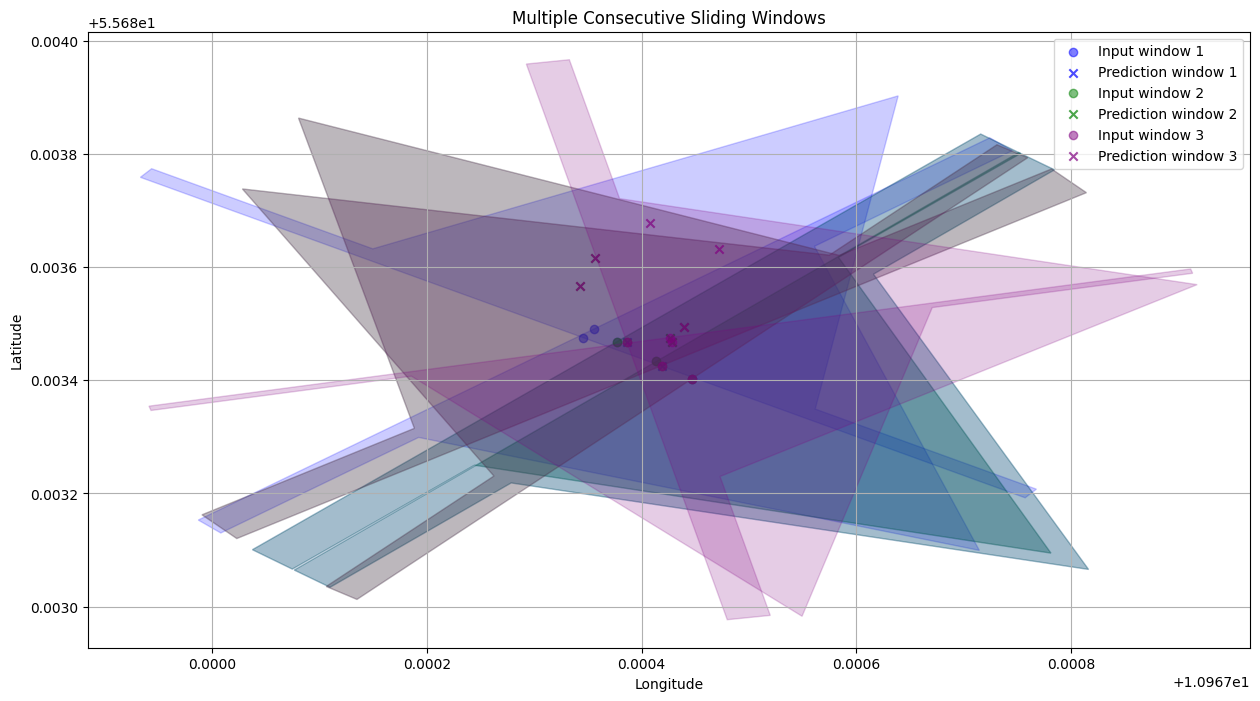


Sliding Window Parameters:
Window size: 60 minutes
Prediction size: 30 minutes
Stride: 12 minutes


AttributeError: 'SlidingWindowDataset' object has no attribute 'max_diff_per_sequence_minutes'

In [ ]:
# Visualize multiple consecutive sliding windows
plt.figure(figsize=(15, 8))

# Get several consecutive windows
num_windows = 3
colors = ['blue', 'green', 'purple']

for i in range(num_windows):
    window_x, window_y = dataset[i]
    
    # Plot input window
    plt.scatter(window_x[:, 1], window_x[:, 0], c=colors[i], alpha=0.5,
                label=f'Input window {i+1}')
    
    # Add arrows for direction
    for j in range(len(window_x)-1):
        plt.arrow(window_x[j, 1], window_x[j, 0],
                 window_x[j+1, 1] - window_x[j, 1],
                 window_x[j+1, 0] - window_x[j, 0],
                 head_width=0.0005, head_length=0.0005,
                 fc=colors[i], ec=colors[i], alpha=0.2)
    
    # Plot prediction window
    plt.scatter(window_y[:, 1], window_y[:, 0], 
                marker='x', c=colors[i], alpha=0.7,
                label=f'Prediction window {i+1}')

plt.title('Multiple Consecutive Sliding Windows')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# Print window parameters
print("\nSliding Window Parameters:")
print(f"Window size: {dataset.window_size_minutes} minutes")
print(f"Prediction size: {dataset.pred_size_minutes} minutes")
print(f"Stride: {dataset.stride} minutes")